# Analyse d'une image de microscopie à l'aide du module scikit image
Ce notebook à pour objectif d'ilustrer une utilisation simplifé du module scikit image pour l'analyse d'une image issue d'un microscope photonique à épifluorescence. On cherche à compter le nombre de noyaux, ainsi que leurs taille et leurs intensité de fluorescence.

## Chargement des modules

In [1]:
# Module standard.
import numpy as np
import matplotlib.pyplot as plt
# Module pour la manipulation d'image (scikit-image).

# sous-module contenant les fonctions de lecture et d'écriture d'une
# image.
import skimage.io
# Sous-module contenant les fonctions ...
import skimage.exposure
# Sous-module contenant les fonctions permettant de réaliser
# des mesures sur les images.
import skimage.measure
# Sous-module contenant les fonctions permmettant de réaliser
# un flitrage des image.
import skimage.filters

# module d'intéraction avec le système
import sys
import os

# Fonction pour le téléchargement de l'image à analiser
from urllib.request import urlretrieve

%matplotlib inline

## Téléchargement et décompréssion de l'image à analyser

In [2]:
# Téléchargement de l'image si elle n'est pas présente dans le répertoire
# courrant.
if not os.path.isfile('FluorescentCells.zip'):
    print('Downloading the TIFF file for fluorescent cells image...')
    try:
        urlretrieve('https://imagej.nih.gov/ij/images/FluorescentCells.zip',
            'FluorescentCells.zip')
        print("ok")
    except:
        print("Unable to download the file!")
    print('Done!')

# Décompression du fichier FluorescentCells.zip si l'image n'est pas
# décompréssée.
if not os.path.isfile("FluorescentCells.tif"):
    !unzip FluorescentCells.zip

## Chargement et visualisation de l'image à analyser

Chargement de l'image dans un array numpy, provennant d'[NIH](https://imagej.nih.gov/ij/images/FluorescentCells.zip).

In [3]:
img = skimage.io.imread("../img/FluorescentCells.tif")

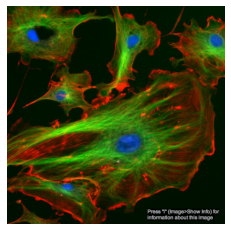

In [4]:
plt.imshow(img)
plt.axis("off");

L'image ci-dessus, que l'on va analyser (dont une description est disponible [ici](https://imagej.nih.gov/ij/images/FluorescentCells.txt)), correspond à une image de cellules endothéliales d'artère pulmonaire bovine. En bleu, il s'agit d'un marquage des noyaux à l'aide du DAPI. En vert, il s'agit d'un marquage de la tubuline. Puis en rouge, il s'agit d'un marquage des microtubules.

In [5]:
print(f"Dimensions du tableau numpy de l'image : {img.shape}")
print(f"Représentation du pixel (0, 0): {img[0, 0, :]}")

Dimensions du tableau numpy de l'image : (512, 512, 3)
Représentation du pixel (0, 0): [16 50  0]


Nous observons que notre image est tridimensionnelles dont la première dimension contient 512 colonnes, la seconde contient 512 ligne et la dernière correspondant aux différents canaux (RGB Dans notre exemple, le pixel (0, 0) à la valeur 16 pour le canal rouge, 50 pour le canal vert et 0 pour le canal bleu.

## Sélection du canal d'intérêt
Le canal d'intérêt est le bleu, puisque qu'il représente les noyaux marqué au DAPI. Il faudra alors utiliser l'indice 2 dans la troisième dimension du tableau numpy pour ce sélectionner ce canal.

In [6]:
canal_blue = img[:, :, 2]

### Affichage du canal d'intérêt

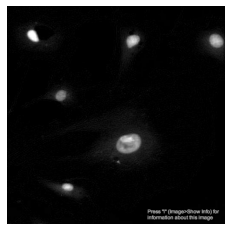

In [7]:
plt.imshow(canal_blue, cmap="gray")
plt.axis("off");

La sélection effectuée permet d'identifier clairement les noyaux. Nous remarquons également en bas à droite une zone de texte qui a été sélectionné. Région qui devra sûrement être filtré par la suite.

## Estimation du seuil de sélection des noyaux

Dans le but de sélectionner les noyaux, il est nécessaire d'utiliser un seuil d'intensité des pixels à conserver pour éliminer le bruit présent sur l'image précédente. Pour ce faire, nous allons réaliser un histogramme en utilsant `skimage.exposure.histogram()`, fonction qui renvoie les valeurs nécessaires à la construction du graphique qui permettra d'identifier le seuil de sélection.

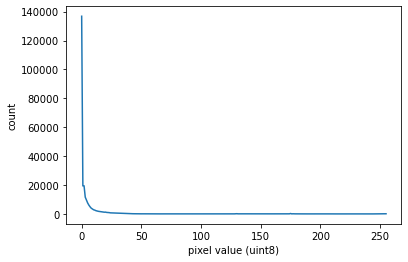

In [8]:
hist, bins = skimage.exposure.histogram(canal_blue)
plt.plot(bins, hist)
# plt.title("fluocells_b pixel values")
plt.xlabel(f"pixel value ({canal_blue.dtype})")
plt.ylabel("count");

La plupart des valeurs de pixel étant nulles (aucune intensité dans le canal bleu), il est impossible de ... . Nous allons donc fixer une valeur limite sur l'axe des abscisses (ici, 100).

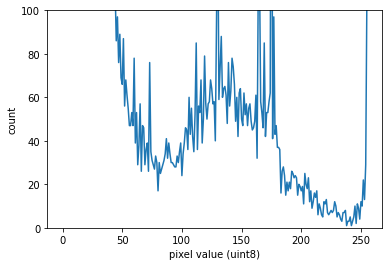

In [9]:
hist, bins = skimage.exposure.histogram(canal_blue)
plt.plot(bins, hist)
plt.ylim(0, 100)
# plt.title("fluocells_b pixel values")
plt.xlabel(f"pixel value ({canal_blue.dtype})")
plt.ylabel("count");

On remarque un minimum local en 80 pour la valeur des pixels. Nous allons donc prendre une valeur de seuil de 80 pour la sélection des noyaux. Nous stockerons ensuite dans l'objet `img_noyau` les pixels dont la valeur est supérieur au seuil définie.

In [10]:
seuil = 80
img_noyau = canal_blue > seuil

### Affichage de l'image après estimation du seuil

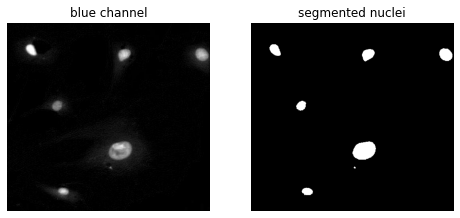

In [12]:
# create subplots to display all images in a single figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 16))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

axes[0].imshow(canal_blue, cmap="gray")
axes[0].set_title("blue channel")

axes[1].imshow(img_noyau, cmap="gray")
axes[1].set_title("segmented nuclei");

Nous constatons que la segmentation a plutôt bien fonctionné : tous les noyaux ont été segmentés. Toutefois, un petit groupe de pixels n'appartenant à aucun noyau se retrouve également segmenté. Comment faire pour éviter cet artefact ? C'est là qu'intervient le filtrage de l'image.

Filtrer une image consiste à la transformer afin de lui faire subir un traitement par la suite, ici une segmentation à l'aide d'une valeur seuil. Nous cherchons ici à obtenir une image du canal bleu où les pixels incorrectement segmentés comme un noyau auraient tous une valeur inférieure au seuil de segmentation utilisé.

(Ce qui distingue ce faux noyau des noyaux authentiques est sa petite aire.)

### Filtrage

Nous allons réduire le bruit en lissant l'image par une méthode de "convolution". Cette méthode revient à calculer une nouvelle valeur pour chaque pixel en faisant la moyenne de ce pixel et des pixels l'entourant, le poids relatif de chaque pixel étant déterminé par les valeurs contenues dans un kernel. On dit qu'on effectue une convolution de l'image avec un kernel. (on dit ça ?)

In [13]:
# est-ce qu'on met l'exemple de https://scikit-image.org/skimage-tutorials/lectures/1_image_filters.html#local-filtering-of-images ?

Ici, nous utiliserons un kernel gaussien, ce qui permet de prendre en compte l'ensemble des pixels entourant le pixel recalculé d'une part, et de donner un poids à chaque pixel en fonction de sa proximité avec le pixel recalculé.

L'image filtrée `fluocells_b_filtered` est obtenue en appliquant sur le canal bleu (`fluocells_b`) la fonction `gaussian()` du sous-module `filters` de *scikit-image*.

In [36]:
fluocells_b_filtered = skimage.filters.gaussian(canal_blue,
                                                sigma=2,
                                                preserve_range=True)

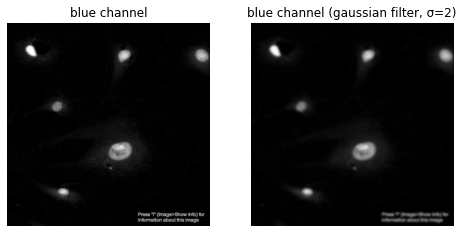

In [37]:
# create subplots to display all images in a single figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 16))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

axes[0].imshow(canal_blue, cmap="gray")
axes[0].set_title("blue channel")

axes[1].imshow(fluocells_b_filtered, cmap="gray")
axes[1].set_title("blue channel (gaussian filter, σ=2)");

Le faux noyau étant directement entouré de pixels ayant des valeurs faibles du fait de sa petite aire, on s'attend à ce que le filtrage réduise davantage son intensité que celle des noyaux authentiques, plus gros.

### Segmentation (après filtrage)

La segmentation est cette fois réalisée sur l'image filtrée.

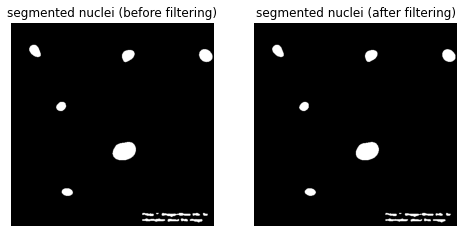

In [39]:
threshold = 80
true_nuclei = (fluocells_b_filtered > threshold)
true_nuclei = true_nuclei.astype(int)

# create subplots to display all images in a single figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 16))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

axes[0].imshow(img_noyau, cmap="gray")
axes[0].set_title("segmented nuclei (before filtering)")

axes[1].imshow(true_nuclei, cmap="gray")
axes[1].set_title("segmented nuclei (after filtering)");

Cette fois, seuls les noyaux ont été segmentés.

Afin de pouvoir pousuivre l'analyse de cette image, nous devons retirer la zone de texte qui pourrait biaisé le résultat.  

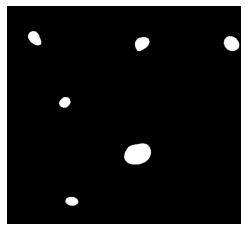

In [40]:
plt.imshow(img_noyau[:476, :], cmap = "gray")
plt.axis("off");

Par la sélection des lignes 0 à 475, on remarque que cela a pu retirer la zone de texte sans perte d'informations pour la suite de notre analyse.

In [50]:
img_noyau = img_noyau[:476, :]
true_nuclei = true_nuclei[:476, :]
canal_blue = canal_blue[:476, :]

### Etiquetage et comptage des noyaux

La fonction `label` du sous-module `measure` de *scikit-image* permet d'étiqueter chaque région contiguë de pixels de même valeur d'un *array* d'entiers. Nous l'utilisons ici sur  pour donner un *label* à chaque noyau. En plus, elle retourne aussi le nombre de régions présentes dans l'*array numpy* avec l'argument `return_num=True`.

In [43]:
# set return_num to True to return the number of labeled regions as well
# background=0 is used to consider 0-valued pixels as background altough also a connected region
nuclei_lab, nuclei_num = skimage.measure.label(true_nuclei, background=0, return_num=True)

print("Number of nuclei:", nuclei_num)

Number of nuclei: 6


Au total, 6 régions, correspondant aux noyaux, ont été identifiées.

(476, 512)
[0 1 2 3 4 5 6]


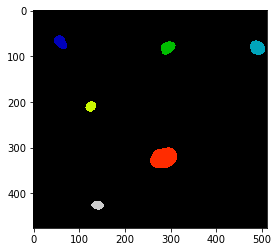

In [63]:
print(nuclei_lab.shape)
print(np.unique(nuclei_lab))
plt.imshow(nuclei_lab, cmap="nipy_spectral", interpolation='none');

L'*array numpy* étiqueté (`nuclei_lab`) est de mêmes dimensions que l'*array* d'origine (`true_nuclei`), mais il comporte 7 valeurs distinctes : une valeur pour les pixels du background, et six autres valeurs (de 1 à 6) pour les 6 noyaux présents sur l'image, comme on le constate en affichant l'image étiquetée en couleurs.

## Mesures

Nous allons effectuer des mesures (aire, intensité) sur les noyaux.

Pour cela, nous commençons par créer un masque booléen pour chacun des 6 noyaux.

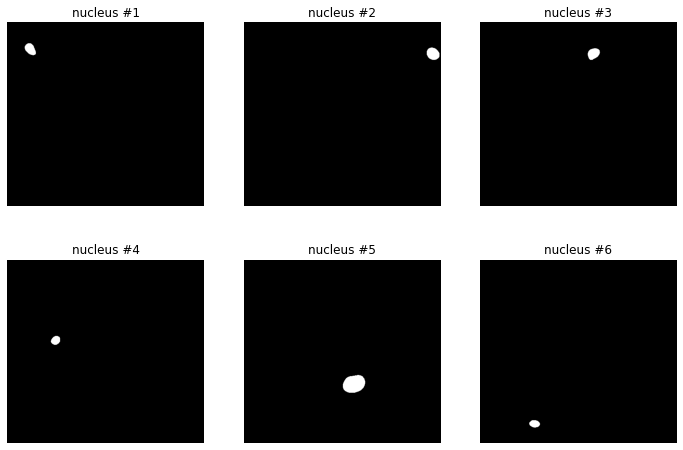

In [45]:
# list to store numpy arrays of each nucleus boolean mask
nuclei_obj = []

# create each nucleus boolean mask using its label and append it to nuclei_obj
for i in range(nuclei_num):
    nuc = (nuclei_lab == i + 1)
    nuclei_obj.append(nuc)

    
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

for i, nuc in enumerate(nuclei_obj):
    axes[i].imshow(nuc, cmap="gray")
    axes[i].set_title("nucleus #" + str(i + 1))

Les *arrays numpy* ainsi créés sont effectivement les masques booléens de chaqun des 6 noyaux.

### Aire des noyaux

Pour mesurer l'aire de chaque noyau, nous comptons le nombre de pixel présent dans chaque région. Les pixels étiquetés ayant pour  valeur `True` et les autres pixels `False`, il suffit de faire la somme des éléments de chaque masque booléen pour obtenir l'aire (en pixel) de chaque noyau.

In [46]:
# measure nuclei areas

# create empty list to  store areas
nuc_areas = []

# measure each nucleus area and append it to nuc_areas
for i in range(nuclei_num):
    area = np.sum(nuclei_obj[i])
    nuc_areas.append(area)
    print(f"nuc_{i + 1} area: {nuc_areas[i]} pixels")

nuc_1 area: 633 pixels
nuc_2 area: 829 pixels
nuc_3 area: 708 pixels
nuc_4 area: 426 pixels
nuc_5 area: 2111 pixels
nuc_6 area: 413 pixels


La distribution de l'aire des noyaux peut être visualisée sous forme d'histogramme.

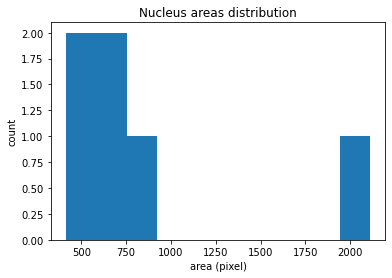

In [47]:
plt.hist(nuc_areas, bins=10)
plt.title("Nucleus areas distribution")
plt.xlabel("area (pixel)")
plt.ylabel("count");

### Intensité moyenne des noyaux

Pour mesurer l'intensité totale de chaque noyau, nous faisons la somme des valeurs d'intensité contenues dans l'*array numpy* du canal bleu (`canal_blue`) associées aux pixels appartenant au noyau mesuré. Chaque intensité totale est ensuite divisée par l'aire du noyau correspondant pour obtenir des intensités moyennes.

In [51]:
# nuclei mean intensities

# create empty list to store mean intensities
nuc_intensities = []

# measure each nucleus intensity and append it to nuc_intensities
for i in range(nuclei_num):
    intensity = np.sum(nuclei_obj[i] * canal_blue) / nuc_areas[i]
    nuc_intensities.append(intensity)
    print(f"nuc_{i + 1} mean intensity: {nuc_intensities[i]:.1f} per pixel")

nuc_1 mean intensity: 194.2 per pixel
nuc_2 mean intensity: 144.1 per pixel
nuc_3 mean intensity: 155.8 per pixel
nuc_4 mean intensity: 115.2 per pixel
nuc_5 mean intensity: 139.5 per pixel
nuc_6 mean intensity: 149.6 per pixel


La distribution de l'intensité moyenne des noyaux peut être visualisée sous forme d'histogramme.

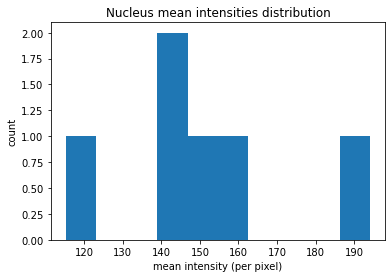

In [52]:
plt.hist(nuc_intensities, bins=10)
plt.title("Nucleus mean intensities distribution")
plt.xlabel("mean intensity (per pixel)")
plt.ylabel("count");

### Mesures avec les fonctions de *scikit-image*

Heureusement, ces mesures peuvent également être effectuées à l'aide du module *scikit-image*. La fonction `regionprops` du sous-module `measure` de *scikit-image* décrit un certain nombre de propriétés associées à chaque région étiquetée, dont l'aire et l'intensité moyenne. Ces propriétés sont accessibles *via* les attributs associés à l'objet renvoyé par la fonction (ici, `.area` pour l'aire, et `mean_intensity` pour l'intensité moyenne).

In [64]:
nuclei_props = skimage.measure.regionprops(nuclei_lab,
                                           intensity_image=canal_blue)

nuclei_props_areas = np.zeros(nuclei_num)
nuclei_props_intensities = np.zeros(nuclei_num)
nuclei_props_perimeters = np.zeros(nuclei_num)
    
for i in range(len(nuclei_props)):
    nuclei_props_areas[i] = nuclei_props[i].area
    nuclei_props_intensities[i] = nuclei_props[i].mean_intensity
    nuclei_props_perimeters[i] = nuclei_props[i].perimeter

Nous pouvons représenter l'aire et l'intensité moyenne de chaque noyau sur le même graphique en traçant un nuage de points.

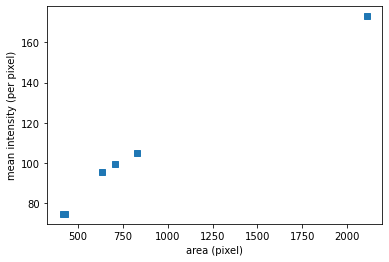

In [55]:
plt.plot(nuclei_props_areas, nuclei_props_intensities, "s")
plt.xlabel("area (pixel)")
plt.ylabel("mean intensity (per pixel)");

**pour le contenu supplémentaire je propose d'effectuer d'autres mesures**\
typiquement regarder les autres propriétés renvoyées par la fonction

On remarque qu'en utilisant un seuil de 80, on a une sélection spécifique des noyaux. Hormis la zone de texte en bas à droite de l'image et d'une petite zone non spécifique d'un noyau.

Afin de pouvoir pousuivre l'analyse de cette image, nous devons retirer la zone de texte qui pourrait biaisé le résultat.  

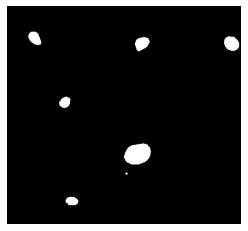

In [12]:
plt.imshow(img_noyau[:476, :], cmap = "gray")
plt.axis("off");

Par la sélection des lignes 0 à 475, on remarque que cela a pu retirer la zone de texte sans perte d'informations pour la suite de notre analyse.

In [13]:
img_noyau = img_noyau[:476, :]

## Comptage des noyaux présents dans notre image 

Nous allons maintenant effectuer le comptage de nos noyaux à l'aide de la fonction `skimage.measure.label()`. 

La fonction a identifié 6 noyaux.


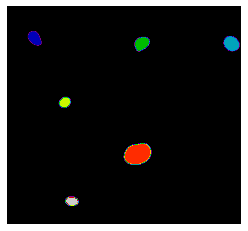

In [62]:
img_noyau_lab, num_noyau = skimage.measure.label(img_noyau, return_num = True)
plt.imshow(img_noyau_lab, cmap = "nipy_spectral")
plt.axis("off")
print(f"La fonction a identifié {num_noyau} noyaux.")

On remarque sous le noyau coloré en jaune sur l'image la présence d'un petit artéfact qui a été comptabilisé comme un noyau. Alors que cela est peu probable qu'il s'agisse d'un noyau.  

## Sélection individuelle des noyaux

In [15]:
noyau_indi = []
for i in range(1, num_noyau + 1):
    noyau_indi.append(img_noyau_lab == i)

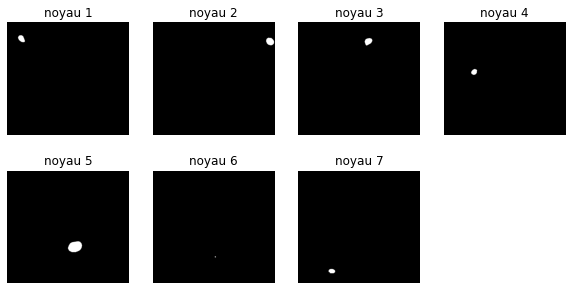

In [31]:
fig, sub = plt.subplots(nrows=2, ncols=4, figsize = (10, 5))
for i in range(4):
    sub[0, i].imshow(noyau_indi[i], cmap="gray")
    sub[0,i].set_title(f"noyau {i + 1}")
    sub[0, i].axis("off")
for i in range(3):
    sub[1, i].imshow(noyau_indi[i+4], cmap="gray")    
    sub[1,i].set_title(f"noyau {i + 5}")

    sub[1, i].axis("off")
sub[1, 3].axis("off");

## Calcul de l'aire des noyaux

Afin de calculer l'aire d'un noyau, nous devons faire la somme des picels allumés par images de noyaux individualisées.

In [17]:
pixel_noyau = []
for noyau in noyau_indi:
    pixel_noyau.append(np.sum(noyau))

for nb_pixel in pixel_noyau:
    print(f"Aire du noyau {pixel_noyau.index(nb_pixel)} = {nb_pixel} pixels")

Aire du noyau 0 = 593 pixels
Aire du noyau 1 = 824 pixels
Aire du noyau 2 = 705 pixels
Aire du noyau 3 = 454 pixels
Aire du noyau 4 = 2097 pixels
Aire du noyau 5 = 18 pixels
Aire du noyau 6 = 406 pixels


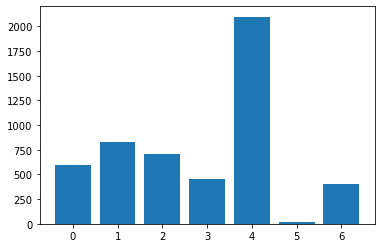

In [18]:
plt.bar(range(7), pixel_noyau);

On observe ici que le noyau 5 a une aire beaucoup plus faible que les autres noyau. Confirmant notre que le noyau 5 semble bien être un artéfact que nous ne prendrons pas en compte lors de la suite de nos analyses.

### Conversion de l'aire des noyaux en $\mu m^2$  

In [19]:
dist_pixel = 0.160
area_noyau = list(np.array(pixel_noyau) * (dist_pixel)**2)
for area in area_noyau:
    print(f"Aire noyau {area_noyau.index(area)} = {area:>6.3f} square microns")

Aire noyau 0 = 15.181 square microns
Aire noyau 1 = 21.094 square microns
Aire noyau 2 = 18.048 square microns
Aire noyau 3 = 11.622 square microns
Aire noyau 4 = 53.683 square microns
Aire noyau 5 =  0.461 square microns
Aire noyau 6 = 10.394 square microns


In [20]:
area_noyau

[15.180800000000001,
 21.0944,
 18.048000000000002,
 11.6224,
 53.6832,
 0.46080000000000004,
 10.393600000000001]

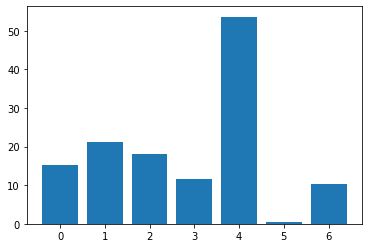

In [21]:
plt.bar(range(7), area_noyau);

In [22]:
area_noyau.pop(5)
pixel_noyau.pop(5)

18

### Ajout d'un filtre gaussien

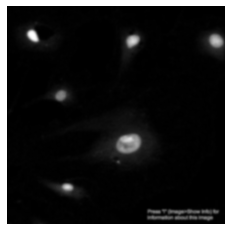

In [23]:
nuclei_filtered = skimage.filters.gaussian(canal_blue, sigma=2)
plt.imshow(nuclei_filtered, cmap="gray")
plt.axis("off");

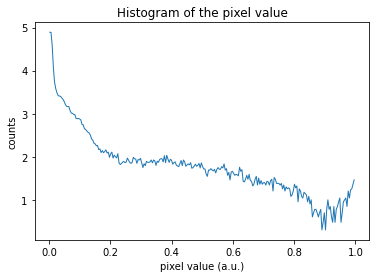

In [24]:
hist, bins = skimage.exposure.histogram(nuclei_filtered)
plt.plot(bins, np.log10(hist+1), linewidth=1)
plt.xlabel('pixel value (a.u.)')
plt.ylabel('counts')
plt.title("Histogram of the pixel value");

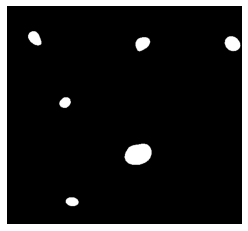

In [25]:
seuil = 0.3
img_noyau = nuclei_filtered > seuil
plt.imshow(img_noyau[:475, :], cmap="gray")
plt.axis("off");

On remarque qu'avec l'application d'un filtre gaussien et l'utilisation d'un seuil de 0.3, on obtient une sélection plus spécifique des nouyaux.

## Comptage du nombre de noyaux

In [26]:
labels, num_noyau = skimage.measure.label(img_noyau[:475,:], return_num = True)
print(labels.shape)
print(num_noyau)

(475, 512)
6


On obtient un comptage de 6 noyaux pour cette image, une fois le texte enlever.